In [1]:
import math, random

import gym
import numpy as np

import mxnet as mx
from mxnet import gluon, autograd, nd
from mxnet.gluon import nn

from tqdm import tqdm, trange
from mxboard import SummaryWriter

In [2]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [3]:
def ger(x1, x2):
    result = list()
    for i in range(x2.shape[0]):      
        tmp = (x1 * x2[i])
        result.append(tmp)
    return nd.stack(*result).T

In [4]:
ctx=mx.gpu()
num_atoms = 51
Vmin = -10
Vmax = 10

In [5]:
from wrappers import make_atari, wrap_deepmind, wrap_mxnet

In [6]:
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env, frame_stack=True)
env    = wrap_mxnet(env)

In [7]:
class NoiseLayer(nn.Block):
    def __init__(self, in_features, out_features, ctx, std_init=0.4, mode='trainig', **kwargs):
        super(NoiseLayer, self).__init__(**kwargs)
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init
        self.mode = mode
        self.ctx=ctx
        
        
        with self.name_scope():
            self.weight_mu = self.params.get('weight_mu', shape=(out_features, in_features))
            self.weight_sigma = self.params.get('weight_sigma', shape=(out_features, in_features))
            self.weight_epsilon = self.params.get('weight_epsilon', shape=(out_features, in_features), grad_req='null')
        
            self.bias_mu = self.params.get('bias_mu', shape=(out_features))
            self.bias_sigma = self.params.get('bias_sigma', shape=(out_features))
            self.bias_epsilon = self.params.get('bias_epsilon', shape=(out_features), grad_req='null')
        self.initiali_idx = 0
    
    def reset_parameters(self):
        mu_range = 1 / math.sqrt(self.weight_mu.shape[1])
        _weight_mu = mx.random.uniform(-mu_range, mu_range, shape=self.weight_mu.shape, ctx=self.ctx)
        self._weight_mu = _weight_mu
#         self.params.setattr('.*weight_mu', _weight_mu)
        with autograd.pause():
            self.weight_mu.set_data(_weight_mu)
        _weight_sigma = nd.zeros(shape=self.weight_sigma.shape, ctx=self.ctx)
        _weight_sigma += self.std_init / math.sqrt(self.weight_sigma.shape[1])
#         self.params.setattr('weight_sigma', _weight_sigma)
        with autograd.pause():
            self.weight_sigma.set_data(_weight_sigma)
        
        _bias_mu = mx.random.uniform(-mu_range, mu_range, shape=self.bias_mu.shape, ctx=self.ctx)
        self.params.setattr('bias_mu', _bias_mu)
        with autograd.pause():
            self.bias_mu.set_data(_bias_mu)
        _bias_sigma = nd.zeros(shape=self.bias_sigma.shape, ctx=self.ctx)
        _bias_sigma += self.std_init / math.sqrt(self.bias_sigma.shape[0])
#         self.params.setattr('bias_sigma', _bias_sigma)
        with autograd.pause():
            self.bias_sigma.set_data(_bias_sigma)
    
    def reset(self):
        self.reset_noise()
        self.reset_parameters()
        
    
    def reset_noise(self):
        epsilon_in = self._scale_noise(self.in_features)
        epsilon_out = self._scale_noise(self.out_features)
        
        _weight_epsilon = ger(epsilon_out, epsilon_in)
        self.params.setattr('weight_epsilon', _weight_epsilon)
        with autograd.pause():
            self.weight_epsilon.set_data(_weight_epsilon)
        _bias_epsilon = self._scale_noise(self.out_features)
        self.params.setattr('bias_epsilon', _bias_epsilon)
        with autograd.pause():
            self.bias_epsilon.set_data(_bias_epsilon)
    
    def _scale_noise(self, size):
        x = nd.random_normal(shape=size)
        x = nd.multiply(x.sign(), x.abs().sqrt())
        return x
        
    
    def forward(self, x):
#         if self.initiali_idx ==0:
#             self.reset_noise()
#             self.reset_parameters()
#             self.initiali_idx +=1
        with x.context:
            if self.mode == 'trainig':
                weight = self.weight_mu.data(self.ctx) + nd.multiply(self.weight_sigma.data(self.ctx), self.weight_epsilon.data(self.ctx))
                bias = self.bias_mu.data() +nd.multiply(self.bias_sigma.data(self.ctx), self.bias_epsilon.data(self.ctx))
            else:
                weight = self.weight_mu.data(self.ctx)
                bias = self.bias_mu.data(self.ctx)
            out = nd.FullyConnected(x, weight, bias, num_hidden=weight.shape[0])
        return out

In [142]:
class RainbowDQN(nn.Block):
    def __init__(self, input_shape, num_actions, num_atoms, Vmin, Vmax, ctx, **kwargs):
        super(RainbowDQN, self).__init__(**kwargs)
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        self.num_atoms = num_atoms
        self.Vmin = Vmin
        self.Vmax = Vmax
        self.ctx = ctx
        
        with self.name_scope():
            self.conv1 = nn.Conv2D(32, 8, 4, in_channels=input_shape[0])
            self.bn1 = nn.BatchNorm()
            self.conv2 = nn.Conv2D(64, 4, 2, in_channels=32)
            self.bn2 = nn.BatchNorm()
            self.conv3 = nn.Conv2D(64, 3, 1, in_channels=64)
            self.bn3 = nn.BatchNorm()
            
            self.noisy_value1 = NoiseLayer(3136, 512, ctx)
            self.noisy_value2 = NoiseLayer(512, self.num_atoms, ctx)
            
            self.noisy_value_adv1 = NoiseLayer(3136, 512, ctx)
            self.noisy_value_adv2 = NoiseLayer(512, self.num_atoms * self.num_actions, ctx)
        
    
    def forward(self, x):
        batch_size = x.shape[0]
        self.noisy_value1.reset()
        self.noisy_value2.reset()
        self.noisy_value_adv1.reset()
        self.noisy_value_adv2.reset()
        
        
        x = x /255.0
        x = self.conv1(x)
        x = self.bn1(x)
        x = nd.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = nd.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = nd.relu(x)
        x = x.reshape(batch_size, -1)
        
        value = nd.relu(self.noisy_value1(x))
        value = self.noisy_value2(value)
        
        adv = nd.relu(self.noisy_value_adv1(x))
        adv = self.noisy_value_adv2(adv)
  
        value = value.reshape(batch_size, 1, self.num_atoms)
        adv = adv.reshape(batch_size, self.num_actions, self.num_atoms)
        
        out = value + adv - nd.mean(adv, axis=1, keepdims=True)
        out = nd.softmax(out.reshape(-1, self.num_atoms)).reshape(-1, self.num_actions, self.num_atoms)
        return out
    
    def reset_noise(self):
        self.noisy_value1.reset_noise()
        self.noisy_value2.reset_noise()
        self.noisy_value_adv1.reset_noise()
        self.noisy_value_adv2.reset_noise()
    
    def act(self, state):
        state = nd.array(np.float32(state), ctx=self.ctx).expand_dims(0)
        dist = self.forward(state)
        dist = dist * nd.array(np.linspace(self.Vmin, self.Vmax, self.num_atoms), ctx=self.ctx)
        action = int(nd.argmax(dist.sum(2),1).asnumpy())
        return action

In [95]:
def proj_distribution(next_state, reward, done, target_model, num_atoms, ctx):
    batch_size = next_state.shape[0]
    
    delta_z = float(Vmax - Vmin) / (num_atoms - 1)
    support = nd.array(np.linspace(Vmin, Vmax, num_atoms), ctx=ctx)
    
    next_dist = target_model(next_state) * support
    next_action = nd.argmax(next_dist.sum(2),1)
    
    action_tmp = nd.stack(nd.arange(next_action.shape[0], ctx=ctx).expand_dims(-1),next_action.expand_dims(-1), axis=0)
    next_dist = nd.gather_nd(next_dist, action_tmp)
    next_dist = next_dist.squeeze()
    
    reward = nd.repeat(reward.expand_dims(1), axis=1, repeats=next_dist.shape[-1])
    done = nd.repeat(done.expand_dims(1), axis=1, repeats=next_dist.shape[-1])
    support = nd.repeat(nd.expand_dims(support,0), axis=0, repeats=next_dist.shape[0])
    
    Tz = reward + (1 - done) * 0.99 * support
    Tz = nd.clip(Tz, a_min=Vmin, a_max=Vmax)
    b  = (Tz - Vmin) / delta_z
    l = b.floor()
    u = b.ceil()
    
    offset = nd.expand_dims(nd.array(np.linspace(0, (batch_size - 1) * num_atoms, batch_size), ctx=ctx), 1)
    offset = nd.repeat(offset,repeats=51, axis=1)
    
    proj_dist = np.zeros(next_dist.shape) 
    index = (l + offset).reshape(-1).asnumpy()
    index = index.astype(int)
    value = (next_dist * (u - b)).reshape(-1).asnumpy()
    np.put(proj_dist.reshape(-1), index, value)
    
    index = (u + offset).reshape(-1).asnumpy()
    index = index.astype(int)
    value = (next_dist * (b - l)).reshape(-1).asnumpy()
    np.put(proj_dist.reshape(-1), index, value)
    proj_dist = nd.array(proj_dist, ctx=ctx)

    return proj_dist

In [157]:
def compute_td_loss(batch_size, current_model, target_model, num_atoms, ctx):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = nd.array((np.float32(state)), ctx=ctx)
    next_state = nd.array(np.float32(next_state), ctx=ctx)
    action     = nd.array((action), ctx=ctx)
    reward     = nd.array((reward), ctx=ctx)
    done       = nd.array((done), ctx=ctx)
        
    proj_dist = proj_distribution(next_state, reward, done, target_model, num_atoms, ctx)
    
    dist = current_model(state)
    action = nd.expand_dims(action, 1)
    
    dist = nd.gather_nd(dist, nd.stack(nd.arange(action.shape[0], ctx=ctx).expand_dims(-1),action.expand_dims(-1), axis=0))
    dist = dist.squeeze()
    dist = nd.clip(dist, 0.01, 0.99)
    loss = -(proj_dist * dist.log()).sum(1)
    loss = loss.mean()
        
    return loss

In [110]:
def update_target(current_model, target_model):
    current_model.save_parameters('./tmp/rainbow_current_model')
    target_model.load_parameters('./tmp/rainbow_current_model')

In [143]:
num_atoms = 51
Vmin = -10
Vmax = 10
batch_size = 32

replay_initial = 10000
replay_buffer = ReplayBuffer(100000)

current_model = RainbowDQN(env.observation_space.shape, env.action_space.n, num_atoms, Vmin, Vmax, ctx)
target_model = RainbowDQN(env.observation_space.shape, env.action_space.n, num_atoms, Vmin, Vmax, ctx)
current_model.initialize(ctx=ctx)
target_model.initialize(ctx=ctx)
trainer = gluon.Trainer(current_model.collect_params(), optimizer='adam', optimizer_params={'learning_rate':0.0001})

In [144]:
num_frames = 1400000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
writer = SummaryWriter(logdir='./logs',filename_suffix="Rainbow")

In [169]:
action

0

In [196]:
state = env.reset()
current_best = -100
for frame_idx in trange(1, num_frames + 1):
    action = current_model.act(state)
   
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        writer.add_scalar("reward", episode_reward, frame_idx)  
        mean_reward = np.mean(all_rewards[-100:])
        print("%d: done %d games, mean reward %.3f, reward %.3f, eps %.2f" % (
                frame_idx, len(all_rewards), mean_reward, episode_reward, epsilon,
            ))
        if current_best < mean_reward:
            print("save current best model")
            current_model.save_parameters('./models/double_dqn_best_model')
            current_best = mean_reward
        episode_reward = 0
        writer.add_scalar("mean_reward", mean_reward, frame_idx)  
        
        
    if len(replay_buffer) > replay_initial:
        with autograd.record():
            loss = compute_td_loss(batch_size, current_model, target_model, num_atoms, ctx)
            loss.backward()
            current_model.reset_noise()
            target_model.reset_noise()
        trainer.step(batch_size)
        losses.append(loss.sum().asscalar())
        writer.add_scalar("loss", loss.mean().asscalar(), frame_idx)   
    if frame_idx % 1000 == 0:
        print("update target model")
        update_target(current_model, target_model)

  0%|          | 24/1400000 [00:47<762:57:07,  1.96s/it]

KeyboardInterrupt: 

In [176]:
state[0]

array([[ 52,  87,  87, ..., 236, 236, 236],
       [ 52,  87,  87, ..., 236, 236, 236],
       [ 52,  87,  87, ..., 236, 236, 236],
       ...,
       [ 87,  87,  87, ..., 236, 236, 236],
       [ 87,  87,  87, ..., 236, 236, 236],
       [ 87,  87,  87, ..., 236, 236, 236]], dtype=uint8)

In [177]:
import gluoncv

In [200]:
state[0].shape

(84, 84)

In [190]:
a = np.expand_dims(state[0], 0)
a = np.transpose(a, axes=(1,2,0))

In [185]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

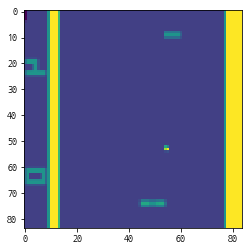

In [202]:
plt.imshow(state[0])